<a href="https://colab.research.google.com/github/zbiswas3/Machine_learning_gatech/blob/master/decision_tree_boosting_Posture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve, validation_curve, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import  SimpleImputer
from sklearn.neighbors import KNeighborsClassifier


from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:

sns.set(rc={'figure.figsize':(12,8.5)})
sns.set_context('poster', font_scale=0.75)


In [3]:
np.random.seed(42)

#INTRODUCTION

## **Utils**

In [4]:
# validatiion curve
def valid_plot(
    X, 
    y, 
    param_range, 
    param_name, 
    estimator, 
    xlabel="parameter", 
    ylabel="accuracy score",  
    title="Validation Curve"
    ):
  train_scores, test_scores = validation_curve(
      estimator,
      X,
      y,
      param_name=param_name,
      param_range=param_range,
      scoring="accuracy",
      n_jobs=2,
      cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
  )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  # plt.ylim(0.0, 1.1)
  lw = 2
  plt.plot(
      param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
  )
  plt.fill_between(
      param_range,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.2,
      color="darkorange",
      lw=lw,
  )
  plt.plot(
      param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
  )
  plt.fill_between(
      param_range,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.2,
      color="navy",
      lw=lw,
  )
  plt.legend(loc="best")
  return plt


In [5]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(26, 8))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


In [6]:
# Calculate bias and variance of the model
def bias_var(y_test, y_pred):
    mean_predictions = np.mean(y_pred, axis=0)
    avg_bias = np.sum((mean_predictions - y_test)**2) / y_test.size
    avg_var = np.sum((mean_predictions - y_pred)**2) / y_pred.size

    return avg_var, avg_bias


## data 

In [7]:
%%capture
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00405/Postures.zip"
!unzip 'Postures.zip'

In [8]:
data = pd.read_csv('Postures.csv')
for val in list(data.columns.values):
    data[val] = pd.to_numeric(data[val], errors='coerce')
    
data=data.sample(frac=0.45, random_state=42)
data.shape


(35143, 38)

## Data analysis

In [9]:
sim = SimpleImputer()

In [10]:
data = pd.DataFrame(sim.fit_transform(data), columns=data.columns)


In [11]:
data = data[data.Class >0]
data['Class'] = data['Class'].astype('int')
data.Class.unique()

array([3, 4, 2, 5, 1])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35142 entries, 0 to 35142
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   35142 non-null  int64  
 1   User    35142 non-null  float64
 2   X0      35142 non-null  float64
 3   Y0      35142 non-null  float64
 4   Z0      35142 non-null  float64
 5   X1      35142 non-null  float64
 6   Y1      35142 non-null  float64
 7   Z1      35142 non-null  float64
 8   X2      35142 non-null  float64
 9   Y2      35142 non-null  float64
 10  Z2      35142 non-null  float64
 11  X3      35142 non-null  float64
 12  Y3      35142 non-null  float64
 13  Z3      35142 non-null  float64
 14  X4      35142 non-null  float64
 15  Y4      35142 non-null  float64
 16  Z4      35142 non-null  float64
 17  X5      35142 non-null  float64
 18  Y5      35142 non-null  float64
 19  Z5      35142 non-null  float64
 20  X6      35142 non-null  float64
 21  Y6      35142 non-null  float64
 22

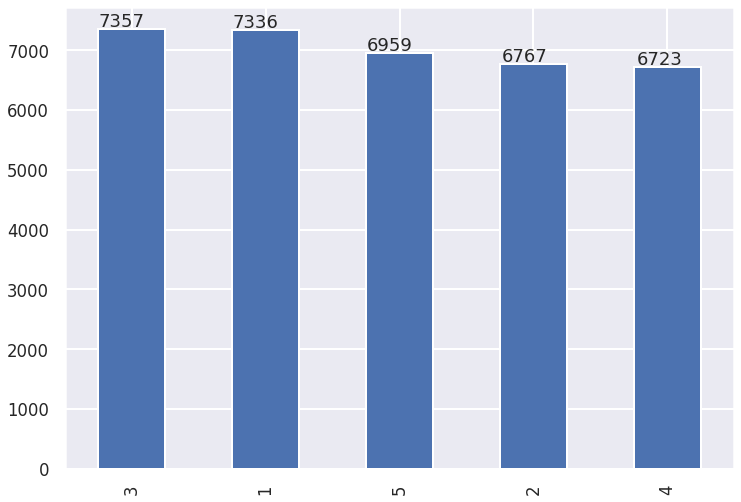

In [13]:
ax = data.Class.value_counts().plot(kind='bar')
try:
  ax.bar_label(ax.containers[0])
except:
  for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

## Data preprocessing

In [14]:
cat_columns = data.select_dtypes('object').columns.tolist()
for col in cat_columns:
  data[col] = data[col].astype('category').cat.codes
data.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,3,6.0,109.240478,44.899381,-60.024315,61.033350,85.559458,-18.295491,68.721592,0.169402,-66.863960,11.542282,84.467412,-33.672673,52.229240,136.226905,-13.461600,92.907674,26.103671,-62.525220,-9.119754,82.657635,-32.104225,44.219670,88.622517,-20.210009,48.058413,86.021193,-24.230812,54.593085,80.971477,-27.625913,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597
1,4,11.0,24.330178,101.140373,1.816550,55.473059,131.027370,13.658764,16.883000,148.501225,6.423454,114.212940,38.602086,-61.127214,72.265570,12.157565,-56.796850,92.830339,28.800005,-60.120643,52.767190,93.407573,-0.229293,44.219670,88.622517,-20.210009,48.058413,86.021193,-24.230812,54.593085,80.971477,-27.625913,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597
2,4,13.0,63.498073,17.176245,-60.413507,74.682024,48.333237,-57.479898,32.838805,147.810305,-12.697328,50.741438,137.808138,-16.903903,71.460231,75.724995,-57.773480,32.572369,99.871957,-8.085566,53.522974,97.148466,-11.820767,44.219670,88.622517,-20.210009,48.058413,86.021193,-24.230812,54.593085,80.971477,-27.625913,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597
3,2,14.0,86.767860,74.450010,-46.187383,57.077763,99.699882,-13.512337,52.828546,151.329974,12.972557,59.619855,36.147365,-56.078468,66.259513,144.173187,-6.390248,16.861316,143.212475,34.183860,13.494791,94.610410,12.191463,-2.985673,123.914195,27.534306,71.138877,56.656104,-49.460886,-9.180367,80.449669,13.646088,38.404759,106.030959,0.419250,-41.541234,24.841743,9.02597
4,5,14.0,-2.025544,99.352134,6.365841,76.213345,33.631282,-41.670484,87.056709,61.502402,-59.262181,-29.853791,77.790630,-17.576383,26.685505,136.893558,-31.884217,55.130637,129.133685,-43.232234,61.867149,101.286413,-6.095230,-2.516153,125.257435,-42.207798,28.077631,108.108797,11.555042,-21.859351,103.919267,-55.090304,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597


## Data split

In [15]:
X, X_test, y, y_test = train_test_split(data[data.columns[2:]], data[data.columns[0]].values, test_size=0.33, random_state=42)

In [16]:
X.shape

(23545, 36)

# Decision Tree Classification


In [17]:
PCA(0.9).fit_transform(X).shape

(23545, 21)

## Gridsearch cross validation

In [ ]:
%%time
model = DecisionTreeClassifier(criterion='entropy')
# define the grid of values to search
grid = dict()
grid['max_depth'] = range(25, 35)
# grid['min_samples_leaf'] = range(0.1, 0.51, 0.1)
grid['max_features'] = range(25, 31)
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose = 10) # f1_macro
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 30 folds for each of 60 candidates, totalling 1800 fits
Best: 0.925731 using {'max_depth': 30, 'max_features': 26}
0.922701 (0.008051) with: {'max_depth': 25, 'max_features': 25}
0.923395 (0.007740) with: {'max_depth': 25, 'max_features': 26}
0.922532 (0.007406) with: {'max_depth': 25, 'max_features': 27}
0.924612 (0.007228) with: {'max_depth': 25, 'max_features': 28}
0.924315 (0.006752) with: {'max_depth': 25, 'max_features': 29}
0.922928 (0.007780) with: {'max_depth': 25, 'max_features': 30}
0.921937 (0.008343) with: {'max_depth': 26, 'max_features': 25}
0.922531 (0.009165) with: {'max_depth': 26, 'max_features': 26}
0.919742 (0.008408) with: {'max_depth': 26, 'max_features': 27}
0.922092 (0.008664) with: {'max_depth': 26, 'max_features': 28}
0.921795 (0.007806) with: {'max_depth': 26, 'max_features': 29}
0.921568 (0.008034) with: {'max_depth': 26, 'max_features': 30}
0.921413 (0.007454) with: {'max_depth': 27, 'max_features': 25}
0.923649 (0.007500) with: {'max_depth': 27, '

In [22]:
%%time
model = DecisionTreeClassifier(criterion='entropy')
# define the grid of values to search
grid = dict()
grid['max_depth'] = range(25, 35)
# grid['min_samples_leaf'] = range(0.1, 0.51, 0.1)
# grid['max_features'] = range(25, 31)
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose = 10) # f1_macro
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: 0.923168 using {'max_depth': 31}
0.922573 (0.006985) with: {'max_depth': 25}
0.921597 (0.005708) with: {'max_depth': 26}
0.921979 (0.006069) with: {'max_depth': 27}
0.922658 (0.005674) with: {'max_depth': 28}
0.921596 (0.006776) with: {'max_depth': 29}
0.922870 (0.006018) with: {'max_depth': 30}
0.923168 (0.005627) with: {'max_depth': 31}
0.921554 (0.006764) with: {'max_depth': 32}
0.922530 (0.006747) with: {'max_depth': 33}
0.923083 (0.006498) with: {'max_depth': 34}
CPU times: user 4.22 s, sys: 202 ms, total: 4.42 s
Wall time: 2min 54s


In [23]:
%%time
model = DecisionTreeClassifier(criterion='entropy')
# define the grid of values to search
grid = dict()
grid['max_depth'] = range(26, 32)
# grid['min_samples_leaf'] = range(0.1, 0.51, 0.1)
grid['max_features'] = range(25, 31)
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose = 10) # f1_macro
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best: 0.926439 using {'max_depth': 29, 'max_features': 30}
0.922234 (0.005133) with: {'max_depth': 26, 'max_features': 25}
0.924782 (0.005376) with: {'max_depth': 26, 'max_features': 26}
0.924102 (0.006547) with: {'max_depth': 26, 'max_features': 27}
0.921342 (0.008784) with: {'max_depth': 26, 'max_features': 28}
0.922319 (0.005606) with: {'max_depth': 26, 'max_features': 29}
0.921851 (0.006194) with: {'max_depth': 26, 'max_features': 30}
0.918921 (0.008191) with: {'max_depth': 27, 'max_features': 25}
0.921213 (0.008772) with: {'max_depth': 27, 'max_features': 26}
0.921894 (0.007323) with: {'max_depth': 27, 'max_features': 27}
0.921936 (0.007016) with: {'max_depth': 27, 'max_features': 28}
0.920450 (0.004789) with: {'max_depth': 27, 'max_features': 29}
0.923890 (0.004837) with: {'max_depth': 27, 'max_features': 30}
0.924654 (0.009445) with: {'max_depth': 28, 'max_features': 25}
0.922149 (0.006945) with: {'max_depth': 28, 'm

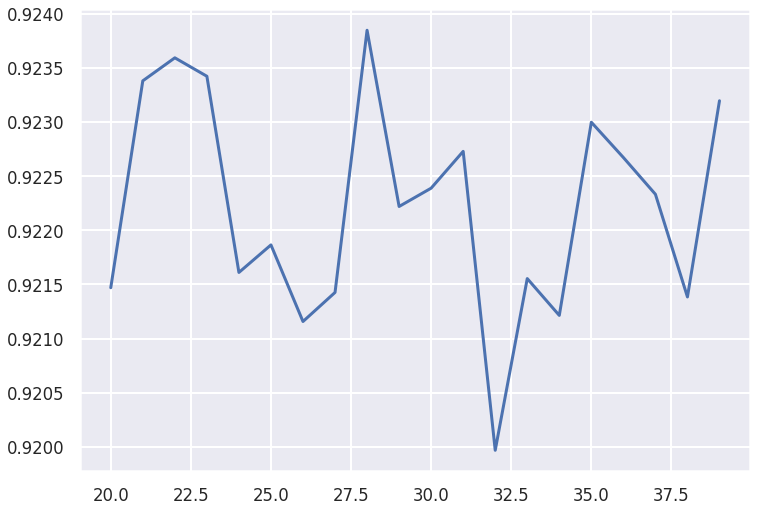

In [ ]:
#  plt.plot(grid["max_depth"], means)

In [ ]:
%%time
model = DecisionTreeClassifier(criterion='entropy')
# define the grid of values to search
grid = dict()
# grid['max_depth'] = range(14, 40)
# grid['min_samples_leaf'] = range(0.1, 0.51, 0.1)
grid['max_features'] = range(14, 32)
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose = 10) # f1_macro
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 30 folds for each of 18 candidates, totalling 540 fits
Best: 0.924004 using {'max_features': 28}
0.915707 (0.009329) with: {'max_features': 14}
0.914179 (0.008693) with: {'max_features': 15}
0.919856 (0.008405) with: {'max_features': 16}
0.919615 (0.007896) with: {'max_features': 17}
0.915821 (0.007389) with: {'max_features': 18}
0.917576 (0.008212) with: {'max_features': 19}
0.917308 (0.006401) with: {'max_features': 20}
0.919912 (0.007114) with: {'max_features': 21}
0.921442 (0.007755) with: {'max_features': 22}
0.917520 (0.009273) with: {'max_features': 23}
0.923112 (0.008397) with: {'max_features': 24}
0.921060 (0.008651) with: {'max_features': 25}
0.923494 (0.006601) with: {'max_features': 26}
0.919955 (0.007530) with: {'max_features': 27}
0.924004 (0.008485) with: {'max_features': 28}
0.922361 (0.008259) with: {'max_features': 29}
0.921059 (0.006173) with: {'max_features': 30}
0.921399 (0.007942) with: {'max_features': 31}
CPU times: user 6.19 s, sys: 527 ms, total: 6.72 

## Final estimator design

In [21]:
estimator = DecisionTreeClassifier(random_state=42, criterion='entropy')

## Validation Curve

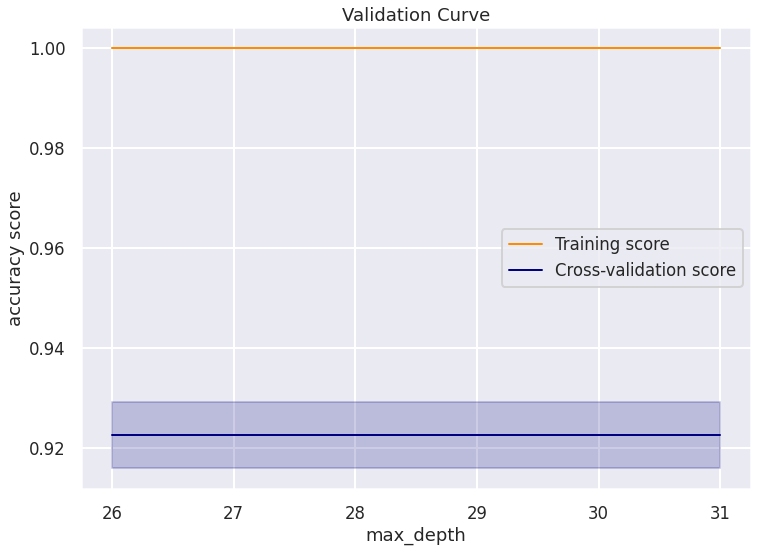

CPU times: user 1.29 s, sys: 103 ms, total: 1.39 s
Wall time: 1min 36s


In [24]:
%%time
valid_plot(    
    X, 
    y, 
    param_range=range(26, 32), 
    param_name='max_depth', 
    estimator=estimator,
    xlabel="max_depth",
    )
plt.show()

In [ ]:
estimator = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=30)

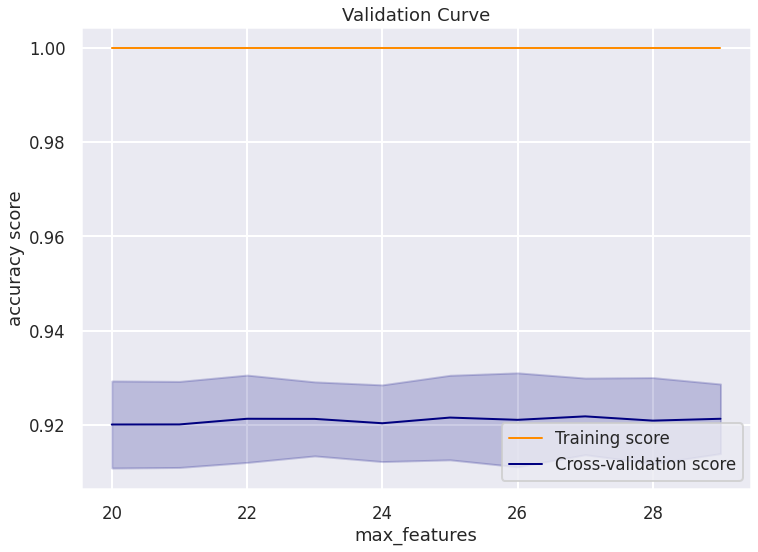

In [ ]:
%%time
valid_plot(    
    X, 
    y, 
    param_name='max_features', 
    param_range=range(20, 30, 1), 
    estimator=estimator, 
    xlabel="max_features")
plt.show()

## Learning Curves

In [25]:
estimator = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=28)

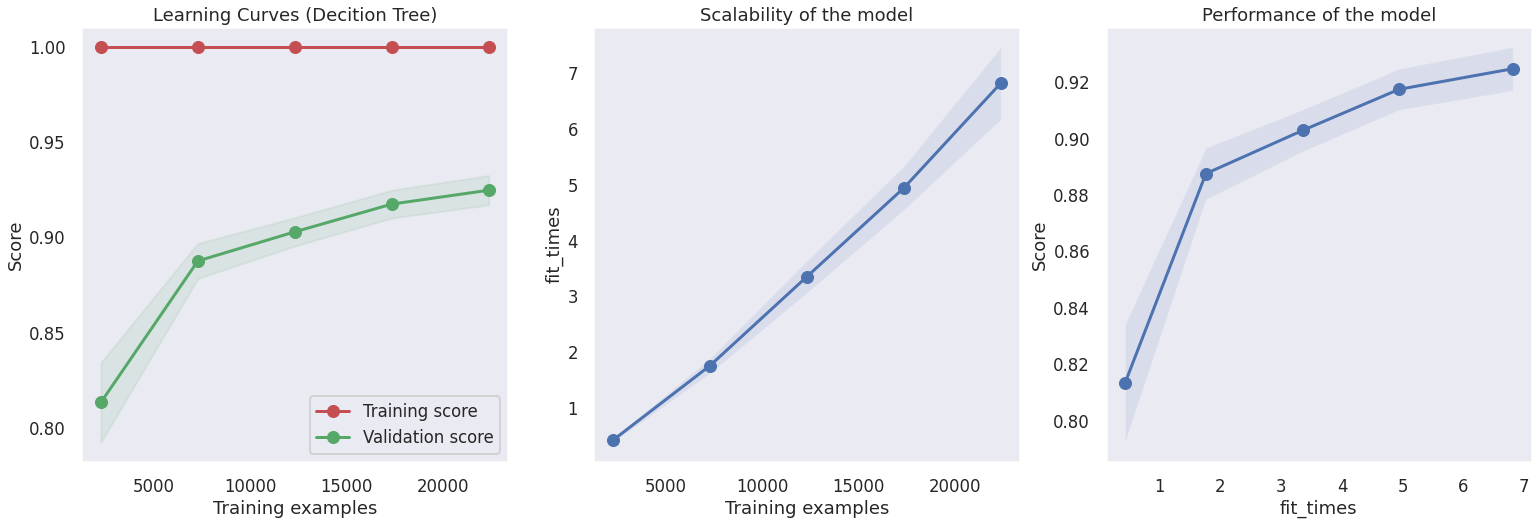

In [26]:
title = "Learning Curves (Decition Tree)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=1, random_state=42)
#  ShuffleSplit(n_splits=50, test_size=0.25, random_state=0)

plot_learning_curve(
    estimator, title, X, y, cv=cv, n_jobs=4
)

plt.show()

## Prediction and accuracy

In [27]:
# estimator = DecisionTreeClassifier(random_state=42, criterion='entropy', max_features=20, max_depth=15)

In [28]:
%%time
estimator.fit(X, y)

CPU times: user 2.34 s, sys: 2.82 ms, total: 2.34 s
Wall time: 2.35 s


DecisionTreeClassifier(criterion='entropy', max_depth=28, random_state=42)

In [29]:
%%time
y_pred = estimator.predict(X_test)

CPU times: user 7.1 ms, sys: 486 µs, total: 7.59 ms
Wall time: 10.2 ms


In [30]:
print("Training Score:", estimator.score(X, y))
print("Testing Score:", estimator.score(X_test, y_test))


Training Score: 1.0
Testing Score: 0.9282573079244633


## Confusion Matrix

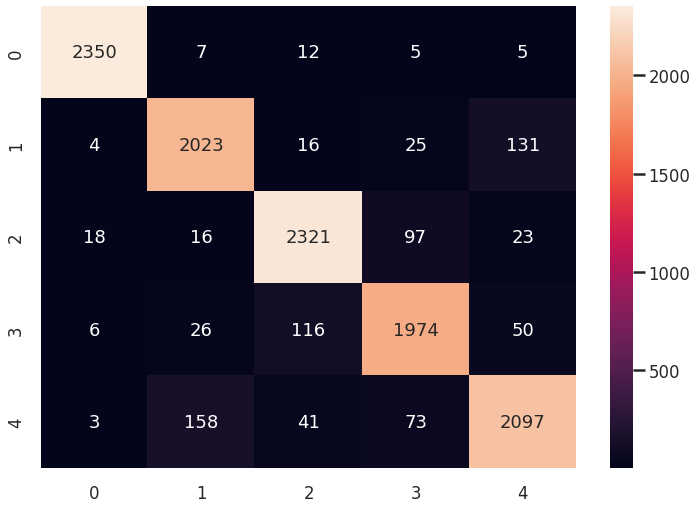

In [31]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

## Bias, variance, and error score

In [32]:
bias_var(y_test, y_pred)

(1.9960628419235455, 2.015797416453689)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2379
           2       0.91      0.92      0.91      2199
           3       0.93      0.94      0.93      2475
           4       0.91      0.91      0.91      2172
           5       0.91      0.88      0.90      2372

    accuracy                           0.93     11597
   macro avg       0.93      0.93      0.93     11597
weighted avg       0.93      0.93      0.93     11597



In [34]:
mean_squared_error(y_test, y_pred)

0.32654996981978096

# KNN Classification


## Gridsearch cross validation

In [ ]:
%%timeit
model = KNeighborsClassifier()
# define the grid of values to search
grid = dict()
grid['n_neighbors'] = range(5, 50, 2)

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

# execute the grid search
grid_result = grid_search.fit(X, y)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.873024 using {'n_neighbors': 5}
0.873024 (0.006301) with: {'n_neighbors': 5}
0.860721 (0.006410) with: {'n_neighbors': 7}
0.850570 (0.007156) with: {'n_neighbors': 9}
0.841071 (0.007509) with: {'n_neighbors': 11}
0.832704 (0.007505) with: {'n_neighbors': 13}
0.824351 (0.007539) with: {'n_neighbors': 15}
0.816281 (0.006993) with: {'n_neighbors': 17}
0.809995 (0.007428) with: {'n_neighbors': 19}
0.804191 (0.007041) with: {'n_neighbors': 21}
0.797891 (0.006939) with: {'n_neighbors': 23}
0.792752 (0.006817) with: {'n_neighbors': 25}
0.786862 (0.006381) with: {'n_neighbors': 27}
0.782261 (0.006438) with: {'n_neighbors': 29}
0.777660 (0.006615) with: {'n_neighbors': 31}
0.773299 (0.006638) with: {'n_neighbors': 33}
0.768585 (0.006939) with: {'n_neighbors': 35}
0.763318 (0.007065) with: {'n_neighbors': 37}
0.759071 (0.007384) with: {'n_neighbors': 39}
0.755235 (0.008200) with: {'n_neighbors': 41}
0.750860 (0.008100) with: {'n_neighbors': 43}
0.746726 (0.007546) with: {'n_neighbors': 4

## Final estimator design

In [17]:
estimator = KNeighborsClassifier()

## Validation Curve

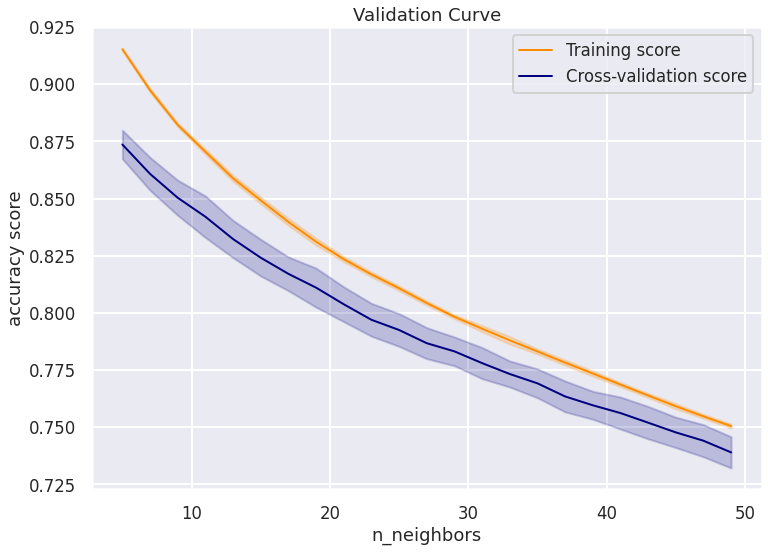

CPU times: user 16 s, sys: 2.01 s, total: 18 s
Wall time: 35min 35s


In [36]:
%%time
valid_plot(    
    X, 
    y, 
    param_range=range(5, 50, 2), 
    param_name='n_neighbors', 
    estimator=estimator,
    xlabel="n_neighbors",
    )
plt.show()

## Learning Curves

In [18]:
estimator = KNeighborsClassifier(n_neighbors=5)

In [ ]:
%%time
title = "Learning Curves (KNN)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#  ShuffleSplit(n_splits=50, test_size=0.25, random_state=0)

plot_learning_curve(
    estimator, title, X, y, cv=cv, n_jobs=4
)

plt.show()

## Prediction and accuracy

In [ ]:
estimator = KNeighborsClassifier(n_neighbors=23)

In [ ]:
%%time
estimator.fit(X, y)

In [ ]:
%%time
y_pred = estimator.predict(X_test)

In [ ]:
print("Training Score:", estimator.score(X, y))
print("Testing Score:", estimator.score(X_test, y_test))


## Confusion Matrix

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

## Bias, variance, and error score

In [ ]:
bias_var(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
mean_squared_error(y_test, y_pred)